# Librerias

In [1]:
import pygame
from pygame import gfxdraw
import numpy as np
from scipy.spatial import distance
from collections import deque
from copy import deepcopy

pygame 2.1.2 (SDL 2.0.18, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Window Class

In [2]:
class Window:
    def __init__(self, sim, config={}):
        # Simulation to draw
        self.sim = sim

        # Set default configurations
        self.set_default_config()

        # Update configurations
        for attr, val in config.items():
            setattr(self, attr, val)
        
    def set_default_config(self):
        """Set default configuration"""
        self.width = 1000
        self.height = 800
        self.bg_color = (250, 250, 250)

        self.fps = 60
        self.zoom = 3
        self.offset = (0, 0)

        self.mouse_last = (0, 0)
        self.mouse_down = False
        
        self.pos = 0
        self.step_size = 0.6
        self.path_taken = 0

    def loop(self, loop=None):
        """Shows a window visualizing the simulation and runs the loop function."""
        
        # Create a pygame window
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.flip()

        # Fixed fps
        clock = pygame.time.Clock()

        # To draw text
        pygame.font.init()
        self.text_font = pygame.font.SysFont('Lucida Console', 16)

        # Draw loop
        running = True
        while running:
            # Update simulation
            if loop: loop(self.sim)

            # Draw simulation
            self.draw()

            # Update window
            pygame.display.update()
            clock.tick(self.fps)

            # Handle all events
            for event in pygame.event.get():
                # Quit program if window is closed
                if event.type == pygame.QUIT:
                    running = False
        pygame.quit()
        
    def run(self, steps_per_update=1):
        """Runs the simulation by updating in every loop."""
        def loop(sim):
            sim.run(steps_per_update)
        self.loop(loop)

    def convert(self, x, y=None):
        """Converts simulation coordinates to screen coordinates"""
        if isinstance(x, list):
            return [self.convert(e[0], e[1]) for e in x]
        if isinstance(x, tuple):
            return self.convert(*x)
        return (
            int(self.width/2 + (x + self.offset[0])*self.zoom),
            int(self.height/2 + (y + self.offset[1])*self.zoom)
        )

    def inverse_convert(self, x, y=None):
        """Converts screen coordinates to simulation coordinates"""
        if isinstance(x, list):
            return [self.convert(e[0], e[1]) for e in x]
        if isinstance(x, tuple):
            return self.convert(*x)
        return (
            int(-self.offset[0] + (x - self.width/2)/self.zoom),
            int(-self.offset[1] + (y - self.height/2)/self.zoom)
        )


    def background(self, r, g, b):
        """Fills screen with one color."""
        self.screen.fill((r, g, b))

    def line(self, start_pos, end_pos, color):
        """Draws a line."""
        gfxdraw.line(
            self.screen,
            *start_pos,
            *end_pos,
            color
        )

    def rect(self, pos, size, color):
        """Draws a rectangle."""
        gfxdraw.rectangle(self.screen, (*pos, *size), color)

    def box(self, pos, size, color):
        """Draws a rectangle."""
        gfxdraw.box(self.screen, (*pos, *size), color)

    def circle(self, pos, radius, color, filled=True):
        gfxdraw.aacircle(self.screen, *pos, radius, color)
        if filled:
            gfxdraw.filled_circle(self.screen, *pos, radius, color)



    def polygon(self, vertices, color, filled=True):
        gfxdraw.aapolygon(self.screen, vertices, color)
        if filled:
            gfxdraw.filled_polygon(self.screen, vertices, color)

    def rotated_box(self, pos, size, angle=None, cos=None, sin=None, centered=True, color=(0, 0, 255), filled=True):
        """Draws a rectangle center at *pos* with size *size* rotated anti-clockwise by *angle*."""
        x, y = pos
        l, h = size

        if angle:
            cos, sin = np.cos(angle), np.sin(angle)
        
        vertex = lambda e1, e2: (
            x + (e1*l*cos + e2*h*sin)/2,
            y + (e1*l*sin - e2*h*cos)/2
        )

        if centered:
            vertices = self.convert(
                [vertex(*e) for e in [(-1,-1), (-1, 1), (1,1), (1,-1)]]
            )
        else:
            vertices = self.convert(
                [vertex(*e) for e in [(0,-1), (0, 1), (2,1), (2,-1)]]
            )

        self.polygon(vertices, color, filled=filled)

    def rotated_rect(self, pos, size, angle=None, cos=None, sin=None, centered=True, color=(0, 0, 255)):
        self.rotated_box(pos, size, angle=angle, cos=cos, sin=sin, centered=centered, color=color, filled=False)

    def arrow(self, pos, size, angle=None, cos=None, sin=None, color=(150, 150, 190)):
        if angle:
            cos, sin = np.cos(angle), np.sin(angle)
        
        self.rotated_box(
            pos,
            size,
            cos=(cos - sin) / np.sqrt(2),
            sin=(cos + sin) / np.sqrt(2),
            color=color,
            centered=False
        )

        self.rotated_box(
            pos,
            size,
            cos=(cos + sin) / np.sqrt(2),
            sin=(sin - cos) / np.sqrt(2),
            color=color,
            centered=False
        )


    def draw_axes(self, color=(100, 100, 100)):
        x_start, y_start = self.inverse_convert(0, 0)
        x_end, y_end = self.inverse_convert(self.width, self.height)
        self.line(
            self.convert((0, y_start)),
            self.convert((0, y_end)),
            color
        )
        self.line(
            self.convert((x_start, 0)),
            self.convert((x_end, 0)),
            color
        )

    def draw_grid(self, unit=50, color=(150,150,150)):
        x_start, y_start = self.inverse_convert(0, 0)
        x_end, y_end = self.inverse_convert(self.width, self.height)

        n_x = int(x_start / unit)
        n_y = int(y_start / unit)
        m_x = int(x_end / unit)+1
        m_y = int(y_end / unit)+1

        for i in range(n_x, m_x):
            self.line(
                self.convert((unit*i, y_start)),
                self.convert((unit*i, y_end)),
                color
            )
        for i in range(n_y, m_y):
            self.line(
                self.convert((x_start, unit*i)),
                self.convert((x_end, unit*i)),
                color
            )
            
    def draw_semaphores(self):
        for semaphore in self.sim.semaphores:
            self.circle(semaphore.posicion, 4, semaphore.luz)

    def draw_roads(self):
        for road in self.sim.roads:
            # Draw road background
            self.rotated_box(
                road.start,
                (road.length, 3.7),
                cos=road.angle_cos,
                sin=road.angle_sin,
                color=(180, 180, 220),
                centered=False
            )
            # Draw road lines
            # self.rotated_box(
            #     road.start,
            #     (road.length, 0.25),
            #     cos=road.angle_cos,
            #     sin=road.angle_sin,
            #     color=(0, 0, 0),
            #     centered=False
            # )

            # Draw road arrow
            if road.length > 5: 
                for i in np.arange(-0.5*road.length, 0.5*road.length, 10):
                    pos = (
                        road.start[0] + (road.length/2 + i + 3) * road.angle_cos,
                        road.start[1] + (road.length/2 + i + 3) * road.angle_sin
                    )

                    self.arrow(
                        pos,
                        (-1.25, 0.2),
                        cos=road.angle_cos,
                        sin=road.angle_sin
                    )   
            


            # TODO: Draw road arrow
     
    
    def draw_status(self):
        text_fps = self.text_font.render(f't={self.sim.t:.5}', False, (0, 0, 0))
        text_frc = self.text_font.render(f'n={self.sim.frame_count}', False, (0, 0, 0))
        
        self.screen.blit(text_fps, (0, 0))
        self.screen.blit(text_frc, (100, 0))


    def draw(self):
        # Fill background
        self.background(*self.bg_color)

        # Major and minor grid and axes
        # self.draw_grid(10, (220,220,220))
        # self.draw_grid(100, (200,200,200))
        # self.draw_axes()

        self.draw_roads()
        self.draw_semaphores()
        #self.draw_vehicles()
        #self.draw_signals()
        
        self.draw_status()
        
        road_index = [7, 0]

        longitud = self.sim.roads[road_index[self.path_taken]].length

        if(self.pos >= longitud):
            self.path_taken = self.path_taken + 1
            self.pos = 0
        if(self.path_taken == len(road_index)):
            self.path_taken = 0
            self.pos = 0

        sin = self.sim.roads[road_index[self.path_taken]].angle_sin
        cos = self.sim.roads[road_index[self.path_taken]].angle_cos
        h=2
        l=2
        x = self.sim.roads[road_index[self.path_taken]].start[0] + cos * self.pos
        y = self.sim.roads[road_index[self.path_taken]].start[1] + sin * self.pos 

        self.rotated_box((x, y), (l, h), cos=cos, sin=sin, centered=True)

        self.pos = self.pos + self.step_size

# Road Class

In [3]:
class Road:
    def __init__(self, start, end):
        self.start = start
        self.end = end

        self.vehicles = deque()

        self.init_properties()

    def init_properties(self):
        self.length = distance.euclidean(self.start, self.end)
        self.angle_sin = (self.end[1]-self.start[1]) / self.length
        self.angle_cos = (self.end[0]-self.start[0]) / self.length
        
    def update(self, dt):
        n = len(self.vehicles)

# Semaforo Class

In [4]:
estados = [(0, 255, 0), (255, 255, 0), (255, 0, 0), (255, 0, 0)] 
        # "green",      "yellow",      "red",       "red"

class Semaforo:
    def __init__(self, estado, posicion):
        self.estado = estado
        self.luz = estados[estado]
        self.posicion = posicion
        
    def Get_Estado(self):
        return self.luz
    
    def Set_Estado(self, estado):
        self.estado = estado
        self.luz = estados[self.estado]
            
    def Siguiente_Estado(self):
        if (self.estado >= (len(estados)-1)):
            self.Set_Estado(0)
        else:
            self.Set_Estado(self.estado + 1)
    
    def delta(self, clock):
        if(clock != 0 and clock % 15 < 0.09):
            self.Siguiente_Estado()

# Simulation Class

In [5]:
class Simulation:
    def __init__(self, config={}):
        # Set default configuration
        self.set_default_config()

        # Update configuration
        for attr, val in config.items():
            setattr(self, attr, val)

    def set_default_config(self):
        self.t = 0.0            # Time keeping
        self.frame_count = 0    # Frame count keeping
        self.dt = 1/60          # Simulation time step
        self.roads = []         # Array to store roads
        self.semaphores = []    # Array to store semaphores

    def create_road(self, start, end):
        road = Road(start, end)
        self.roads.append(road)
        return road
    
    def create_semaphores(self, semaphore_list):
        for semaphore in semaphore_list:
            new_semaphore = Semaforo(*semaphore)
            self.semaphores.append(new_semaphore)

    def create_roads(self, road_list):
        for road in road_list:
            self.create_road(*road)

    def update(self):
        # Update every road
        for road in self.roads:
            road.update(self.dt)

        for semaphore in self.semaphores:
            semaphore.delta(self.t)
        
        # Increment time
        self.t += self.dt
        self.frame_count += 1


    def run(self, steps):
        for _ in range(steps):
            self.update()



# Running Program

In [18]:
sim = Simulation()

# Add multiple roads
sim.create_roads([
    
    #down -upper section
    ((0,-100),(0,0)), 
    ((5,-100),(5,0)),
    
    #down -lower section
    ((0,8),(0,120)), 
    ((5,8),(5,120)),
    
    #right -left section
    ((-100,2),(-2,2)), 
    ((-100,7),(-2,7)),
    
    #right -right section
    ((7,2),(130,2)), 
    ((7,7),(130,7))
    
])

#Add multiple semaphores
sim.create_semaphores([
    (0, (500, 390)), 
    (2, (530, 420)),
    (0, (515, 390)),
    (2, (530, 407))
    
])

# Start simulation
win = Window(sim)
#win.offset = (-150, -90)
win.offset = (0, 0)
win.run(steps_per_update=5)

In [ ]:
# Networkx para grafos
import networkx as nx

# Pandas
import pandas as pd

# Mostrar imágenes
from IPython.display import HTML

# Mathplotlib
import matplotlib.pyplot as plt

  
rutas = pd.read_csv("datos.csv")
rutas.head(20)

In [17]:
DG=nx.DiGraph()
for row in rutas.iterrows():
    DG.add_edge(row[1]["Origen"],
                row[1]["Destino"],
                duration=row[1]["Costo"])

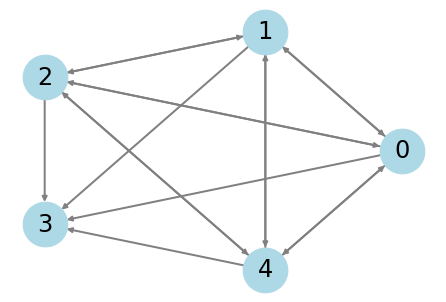

In [25]:
nx.draw_circular(DG,
                 node_color="lightblue",
                 edge_color="gray",
                 font_size=24,
                 width=2, with_labels=True, node_size=2000,
)

In [24]:
list(nx.dijkstra_path(DG, source=4, target=2, weight="Costo"))

[4, 2]

In [26]:
def show_path(path):
    total_price = 0
   
    
    for i in range(len(path)-1):
        origin = path[i]
        destination = path[i+1]
      
        price = DG[origin][destination]["Costo"]
        
        total_price = total_price+price
        
        print("    %s -> %s\n    - Price: %s €" % (
            rutas.loc[origin]["name"],
            rutas.loc[destination]["name"],
            price)
        )
    
    print("\n     Total Duration: %s Total price: %s € \n" % (
            total_duration, total_price)
    )